In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/marvinbertin/anaconda/envs/TensorFlow-env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def dptable(state_prob):
    print(" ".join(("%10d" % i) for i in range(state_prob.shape[0])))
    for i, prob in enumerate(state_prob.T):
        print("%.7s: " % states[i] +" ".join("%.7s" % ("%f" % p) for p in prob))

In [3]:
class HiddenMarkovModel(object):

    """
    Hidden Markov Model Class

    Parameters:
    -----------
    
    - S: Number of states.
    - T: Transition matrix of size S by S
         stores probability from state i to state j.
    - E: Emission matrix of size S by N (number of observations)
         stores the probability of observing  O_j  from state  S_i. 
    - T0: Initial state probabilities of size S.
    """

    def __init__(self, T, E, T0, epsilon = 0.001, maxStep = 10):
        
        with tf.name_scope('Inital_Parameters'):
            with tf.name_scope('Scalar_constants'):
                # Max number of iteration
                self.maxStep = maxStep

                # convergence criteria
                self.epsilon = epsilon 

                # Number of possible states
                self.S = T.shape[0]

                # Number of possible observations
                self.O = E.shape[0]
                
                self.prob_state_1 = []

            with tf.name_scope('Model_Parameters'):
                # Emission probability
                self.E = tf.Variable(E, dtype=tf.float64, name='emission_matrix')

                # Transition matrix
                self.T = tf.Variable(T, dtype=tf.float64, name='transition_matrix')

                # Initial state vector
                self.T0 = tf.Variable(tf.constant(T0, dtype=tf.float64, name='inital_state_vector'))
    

    def initialize_viterbi_variables(self, shape):
        
        pathStates = tf.Variable(tf.zeros(shape, dtype=tf.int64), name='States_matrix')
        pathScores = tf.Variable(tf.zeros(shape, dtype=tf.float64), name='Score_matrix')
        states_seq = tf.Variable(tf.zeros([shape[0]], dtype=tf.int64), name='States_sequence')
        return pathStates, pathScores, states_seq
    
    def belief_propagation(self, scores):
        
        scores_reshape = tf.reshape(scores, (-1,1))
        return tf.add(scores_reshape, tf.log(self.T))
    
    def viterbi_inference(self, obs_seq):
        
        # length of observed sequence
        self.N = len(obs_seq)
        
        # shape path Variables
        shape = [self.N, self.S]
        
        # observed sequence
        x = tf.constant(obs_seq, dtype=tf.int32, name='observation_sequence')
        
        with tf.name_scope('Init_viterbi_variables'):
            # Initialize variables
            pathStates, pathScores, states_seq = self.initialize_viterbi_variables(shape)       
        
        with tf.name_scope('Emission_seq_'):
            # log probability of emission sequence
            obs_prob_seq = tf.log(tf.gather(self.E, x))
            obs_prob_list = tf.split(0, self.N, obs_prob_seq)

        with tf.name_scope('Starting_log-priors'):
            # initialize with state starting log-priors
            pathScores = tf.scatter_update(pathScores, 0, tf.log(self.T0) + tf.squeeze(obs_prob_list[0]))
            
        
        with tf.name_scope('Belief_Propagation'):
            for step, obs_prob in enumerate(obs_prob_list[1:]):

                with tf.name_scope('Belief_Propagation_step_%s' %step):
                    # propagate state belief
                    belief = self.belief_propagation(pathScores[step, :])

                    # the inferred state by maximizing global function
                    # and update state and score matrices 
                    pathStates = tf.scatter_update(pathStates, step + 1, tf.argmax(belief, 0))
                    pathScores = tf.scatter_update(pathScores, step + 1, tf.reduce_max(belief, 0) + tf.squeeze(obs_prob))

            with tf.name_scope('Max_Likelyhood_update'):
                # infer most likely last state
                states_seq = tf.scatter_update(states_seq, self.N-1, tf.argmax(pathScores[self.N-1, :], 0))
        
        with tf.name_scope('Backtrack'):
            for step in range(self.N - 1, 0, -1):
                with tf.name_scope('Back_track_step_%s' %step):
                    # for every timestep retrieve inferred state
                    state = states_seq[step]
                    idx = tf.reshape(tf.pack([step, state]), [1, -1])
                    state_prob = tf.gather_nd(pathStates, idx)
                    states_seq = tf.scatter_update(states_seq, step - 1,  state_prob[0])

        return states_seq, tf.exp(pathScores) # turn scores back to probabilities
    
    def run_viterbi(self, obs_seq, summary=False):
        
        state_graph, state_prob_graph = self.viterbi_inference(obs_seq)
        
        with tf.Session() as sess:
            
            sess.run(tf.initialize_all_variables())
            states_seq, state_prob = sess.run([state_graph, state_prob_graph])
            
            if summary:
                # Instantiate a SummaryWriter to output summaries and the Graph.
                summary_writer = tf.train.SummaryWriter('logs/', graph=sess.graph)

        return states_seq, state_prob
    
    def initialize_forw_back_variables(self, shape):
        self.forward = tf.Variable(tf.zeros(shape, dtype=tf.float64), name='forward')
        self.backward = tf.Variable(tf.zeros(shape, dtype=tf.float64), name='backward')
        self.posterior = tf.Variable(tf.zeros(shape, dtype=tf.float64), name='posteriror')


    def _forward(self, obs_prob_list):
        
        with tf.name_scope('init_scaling_factor'):
            self.scale = tf.Variable(tf.zeros([self.N], tf.float64)) #scale factors
        
        with tf.name_scope('forward_first_step'):
            # initialize with state starting priors
            init_prob = tf.mul(self.T0, tf.squeeze(obs_prob_list[0]))

            # scaling factor at t=0
            self.scale = tf.scatter_update(self.scale, 0, 1.0 / tf.reduce_sum(init_prob))

            # scaled belief at t=0
            self.forward = tf.scatter_update(self.forward, 0, self.scale[0] * init_prob)

        # propagate belief
        for step, obs_prob in enumerate(obs_prob_list[1:]):
            with tf.name_scope('time_step-%s' %step):
                # previous state probability
                prev_prob = tf.expand_dims(self.forward[step, :], 0)
                # transition prior
                prior_prob = tf.matmul(prev_prob, self.T)
                # forward belief propagation
                forward_score = tf.mul(prior_prob, tf.squeeze(obs_prob))

                forward_prob = tf.squeeze(forward_score)
                # scaling factor
                self.scale = tf.scatter_update(self.scale, step+1, 1.0 / tf.reduce_sum(forward_prob))
                # Update forward matrix
                self.forward = tf.scatter_update(self.forward, step+1, self.scale[step+1] * forward_prob)
        

    def _backward(self, obs_prob_list):
        with tf.name_scope('backward_last_step'):
            # initialize with state ending priors
            self.backward = tf.scatter_update(self.backward, 0, self.scale[self.N-1] * tf.ones([self.S], dtype=tf.float64)) 

        # propagate belief
        for step, obs_prob in enumerate(obs_prob_list[:-1]):
            with tf.name_scope('time_step-%s' %step):
                # next state probability
                next_prob = tf.expand_dims(self.backward[step, :], 1)
                # observation emission probabilities
                obs_prob_d = tf.diag(tf.squeeze(obs_prob))
                # transition prior
                prior_prob = tf.matmul(self.T, obs_prob_d)
                # backward belief propagation
                backward_score = tf.matmul(prior_prob, next_prob)

                backward_prob = tf.squeeze(backward_score)

                # Update backward matrix
                self.backward = tf.scatter_update(self.backward, step+1, self.scale[self.N-2-step] * backward_prob)
        
        self.backward = tf.assign(self.backward, tf.reverse(self.backward, [True, False]))

        
    def _posterior(self):
        # posterior score
        self.posterior = tf.mul(self.forward, self.backward)

        marginal = tf.reduce_sum(self.posterior, 1)
        self.posterior = self.posterior / tf.expand_dims(marginal, 1)       
        
        
    def re_estimate_emission(self, x):
        
        states_marginal = tf.reduce_sum(self.gamma, 0)
        seq_one_hot = tf.one_hot(tf.cast(x, tf.int64), self.O, 1, 0)
        emission_score = tf.matmul(tf.cast(seq_one_hot, tf.float64), self.gamma, transpose_a=True)
        return emission_score / states_marginal
    
    def re_estimate_transition(self, x):
        
        with tf.name_scope('Init_3D_tensor'):
            self.M = tf.Variable(tf.zeros((self.N-1, self.S, self.S), tf.float64))
        
        with tf.name_scope('3D_tensor_transition'):
            for t in range(self.N - 1):
                with tf.name_scope('time_step-%s' %t):
                    tmp_0 = tf.matmul(tf.expand_dims(self.forward[t, :], 0), self.T)
                    tmp_1 = tf.mul(tmp_0, tf.expand_dims(tf.gather(self.E, x[t+1]), 0))
                    denom = tf.squeeze(tf.matmul(tmp_1, tf.expand_dims(self.backward[t+1, :], 1)))

                with tf.name_scope('Init_new_transition'):
                    trans_re_estimate = tf.Variable(tf.zeros((self.S, self.S), tf.float64))
                    
                for i in range(self.S):
                    with tf.name_scope('State-%s' %i):
                        numer = self.forward[t, i] * self.T[i, :] * tf.gather(self.E, x[t+1]) * self.backward[t+1, :]
                        trans_re_estimate = tf.scatter_update(trans_re_estimate, i, numer / denom)

                self.M = tf.scatter_update(self.M, t, trans_re_estimate)

        with tf.name_scope('Smooth_gamma'):
            self.gamma = tf.squeeze(tf.reduce_sum(self.M, 2))
            T_new = tf.reduce_sum(self.M, 0) / tf.expand_dims(tf.reduce_sum(self.gamma, 0), 1)
        
        with tf.name_scope('New_init_states_prob'):
            T0_new = self.gamma[0,:]

        with tf.name_scope('Append_gamma_final_time_step'):
            prod = tf.expand_dims(tf.mul(self.forward[self.N-1, :], self.backward[self.N-1, :]), 0)
            s= prod/ tf.reduce_sum(prod)
            self.gamma = tf.concat(0, [self.gamma, s])
            
            self.prob_state_1.append(self.gamma[:, 1])
        
        return T0_new, T_new
    
    def check_convergence(self, new_T0, new_transition, new_emission):
        
        delta_T0 = tf.reduce_max(tf.abs(self.T0 - new_T0)) < self.epsilon
        delta_T = tf.reduce_max(tf.abs(self.T - new_transition)) < self.epsilon
        delta_E = tf.reduce_max(tf.abs(self.E - new_emission)) < self.epsilon

        return tf.logical_and(tf.logical_and(delta_T0, delta_T), delta_E)
        
    def forward_backward(self, obs_prob_seq):
        """
        runs forward backward algorithm on observation sequence

        Arguments
        ---------
        - obs_seq : matrix of size N by S, where N is number of timesteps and
            S is the number of states

        Returns
        -------
        - forward : matrix of size N by S representing
            the forward probability of each state at each time step
        - backward : matrix of size N by S representing
            the backward probability of each state at each time step
        - posterior : matrix of size N by S representing
            the posterior probability of each state at each time step
        """
        obs_prob_list_for = tf.split(0, self.N, obs_prob_seq)
        
        with tf.name_scope('forward_belief_propagation'):
            # forward belief propagation
            self._forward(obs_prob_list_for)

        obs_prob_seq_rev = tf.reverse(obs_prob_seq, [True, False])
        obs_prob_list_back = tf.split(0, self.N, obs_prob_seq_rev)

        with tf.name_scope('backward_belief_propagation'):
            # backward belief propagation
            self._backward(obs_prob_list_back)
        
    def expectation_maximization_step(self, x):
        
        # probability of emission sequence
        obs_prob_seq = tf.gather(self.E, x)

        with tf.name_scope('Forward_Backward'):
            self.forward_backward(obs_prob_seq)

        with tf.name_scope('Re_estimate_transition'):
            new_T0, new_transition = self.re_estimate_transition(x)
        
        with tf.name_scope('Re_estimate_emission'):
            new_emission = self.re_estimate_emission(x)

        with tf.name_scope('Check_Convergence'):
            converged = self.check_convergence(new_T0, new_transition, new_emission)

        with tf.name_scope('Update_parameters'):
            self.T0 = tf.assign(self.T0, new_T0)
            self.E = tf.assign(self.E, new_emission)
            self.T = tf.assign(self.T, new_transition)
            #self.count = tf.assign_add(self.count, 1)
             
            with tf.name_scope('histogram_summary'):
                _ = tf.histogram_summary(self.T0.name, self.T0)
                _ = tf.histogram_summary(self.T.name, self.T)
                _ = tf.histogram_summary(self.E.name, self.E)
        return converged
        
    
    def Baum_Welch_EM(self, obs_seq):
        
        with tf.name_scope('Input_Observed_Sequence'):
            # length of observed sequence
            self.N = len(obs_seq)

            # shape of Variables
            shape = [self.N, self.S]

            # observed sequence
            x = tf.constant(obs_seq, dtype=tf.int32, name='observation_sequence')
        
        with tf.name_scope('Initialize_variables'):
            # initialize variables
            self.initialize_forw_back_variables(shape)
        
        converged = tf.cast(False, tf.bool)
        #self.count = tf.Variable(tf.constant(0))
        
        with tf.name_scope('Train_Baum_Welch'):
            for i in range(self.maxStep):
                
                with tf.name_scope('EM_step-%s' %i):
                    converged = self.expectation_maximization_step(x)

#         TF while_loop op is buggy, should be fixed in future release
#         def loop_conditions(converged, obs_seq):
#             cond_1 = tf.logical_not(converged)
#             cond_2 = tf.less(self.count, self.maxStep)
#             return tf.logical_or(cond_1, cond_2)
        
#         def body(converged, obs_seq):
#             return self.expectation_maximization_step(obs_seq)
        
#         while_params = [converged, obs_seq]
#         c = tf.while_loop(loop_conditions, body, while_params)
      
        return converged
    
    def run_Baum_Welch_EM(self, obs_seq, summary=False, monitor_state_0=False):
        
        converged = self.Baum_Welch_EM(obs_seq)
        
        # Build the summary operation based on the TF collection of Summaries.
        summary_op = tf.merge_all_summaries()
        
        with tf.Session() as sess:
            
            sess.run(tf.initialize_all_variables())
            trans0, transition, emission, c = sess.run([self.T0, self.T, self.E, converged])
            
            if monitor_state_0:
                self.state_summary = np.array([sess.run(g) for g in self.prob_state_1])
            
            if summary:
                # Instantiate a SummaryWriter to output summaries and the Graph.
                summary_writer = tf.train.SummaryWriter('logs/', graph=sess.graph)
                
                summary_str = sess.run(summary_op)
                summary_writer.add_summary(summary_str)

            return trans0, transition, emission, c

In [4]:
p0 = np.array([0.6, 0.4])

emi = np.array([[0.5, 0.1],
                [0.4, 0.3],
                [0.1, 0.6]])

trans = np.array([[0.7, 0.3],
                  [0.4, 0.6]])

states = {0:'Healthy', 1:'Fever'}
obs = {0:'normal', 1:'cold', 2:'dizzy'}

obs_seq = np.array([0, 1, 2])

In [5]:
model =  HiddenMarkovModel(trans, emi, p0)
states_seq, state_prob = model.run_viterbi(obs_seq, summary=True)
dptable(state_prob)
print()
print("Most likely States: ", [states[s] for s in states_seq])

         0          1          2
Healthy: 0.30000 0.08400 0.00588
Fever: 0.04000 0.02700 0.01512

Most likely States:  ['Healthy', 'Healthy', 'Fever']


In [6]:
def generate_HMM_observation(num_obs, pi, T, E):
    def drawFrom(probs):
        return np.where(np.random.multinomial(1,probs) == 1)[0][0]

    obs = np.zeros(num_obs)
    states = np.zeros(num_obs)
    states[0] = drawFrom(pi)
    obs[0] = drawFrom(E[:, int(states[0])])
    for t in range(1,num_obs):
        states[t] = drawFrom(T[int(states[t-1]),:])
        obs[t] = drawFrom(E[:, int(states[t])])
    return obs, states

In [7]:

True_pi = np.array([0.5, 0.5])

True_T = np.array([[0.85, 0.15],
                  [0.12, 0.88]])

True_E = np.array([[0.8, 0.0],
                   [0.1, 0.0],
                   [0.1, 1.0]])

In [8]:
obs_seq, states = generate_HMM_observation(50, True_pi, True_T, True_E)

In [9]:
print(obs_seq)
print(states)

[ 0.  1.  0.  2.  2.  2.  2.  2.  2.  0.  0.  0.  0.  0.  0.  2.  0.  0.
  0.  2.  0.  0.  0.  0.  0.  0.  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.]
[ 0.  0.  0.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [10]:
init_pi = np.array([0.5, 0.5])

init_T = np.array([[0.5, 0.5],
                  [0.5, 0.5]])

init_E = np.array([[0.3, 0.2],
                   [0.3, 0.5],
                   [0.4, 0.3]])


In [11]:
model =  HiddenMarkovModel(init_T, init_E, init_pi, epsilon=0.0001, maxStep=8)

trans0, transition, emission, c = model.run_Baum_Welch_EM(obs_seq, summary=False, monitor_state_0=True)

print(transition)
print()
print(emission)
print()
print(c)

[[ 0.56776236  0.43223764]
 [ 0.55756946  0.44243054]]

[[ 0.37814464  0.28973823]
 [ 0.03760028  0.08951528]
 [ 0.58425509  0.62074649]]

True


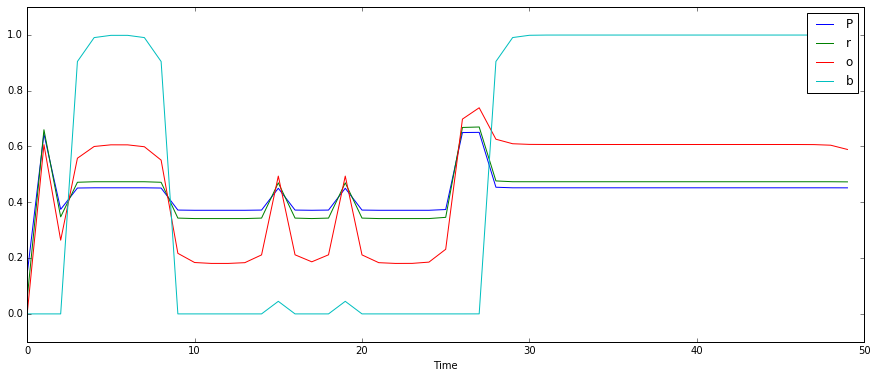

In [16]:

plt.figure(figsize=(15,6))
#plt.plot(gamma.T)
plt.plot(model.state_summary[0::2].T)
plt.ylim(-0.1,1.1)
#plt.figure(figsize=(12,6))
plt.legend(('Probability State=1'))
plt.xlabel('Time')
plt.draw()

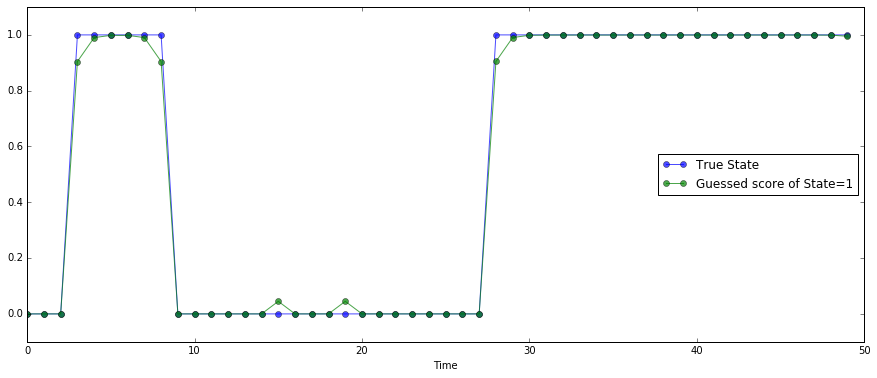

In [13]:
plt.figure(figsize=(15,6))
plt.plot(states.T,'-o',alpha=0.7)
plt.plot(model.state_summary[-1].T, '-o',alpha=0.7)
plt.legend(('True State','Guessed score of State=1'), loc = 'center right')
plt.ylim(-0.1,1.1)
plt.xlabel('Time')
plt.draw()

In [14]:
pred = model.state_summary[-1] > 0.5
print("Accuracy: ", np.mean(pred == states))

Accuracy:  1.0


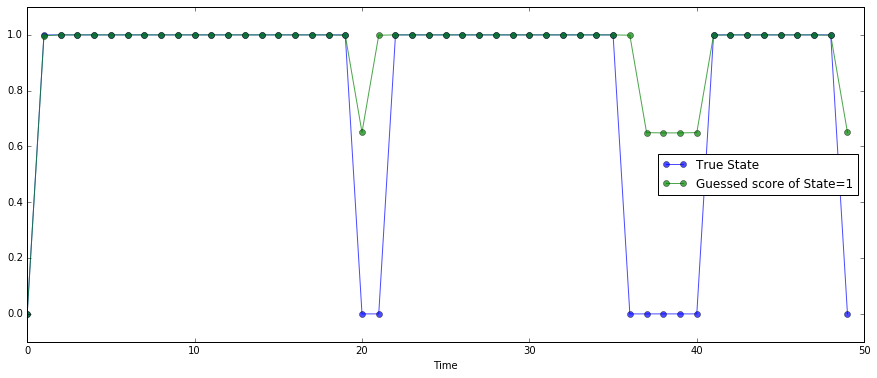

In [33]:
plt.figure(figsize=(15,6))
plt.plot(np.vstack((states,new_g)).T,'-o',alpha=0.7)
plt.legend(('True State','Guessed score of State=1'), loc = 'center right')
plt.ylim(-0.1,1.1)
plt.xlabel('Time')
plt.draw()

Accuracy:  0.96


In [23]:
model =  HiddenMarkovModel(transition, emission, trans0)
states_seq, state_prob = model.run_viterbi(obs_seq, summary=False)
#dptable(state_prob)
print("Accuracy: ", np.mean((states_seq + 1) == states))
#print("Most likely States: ", [states[s] for s in states_seq])

Accuracy:  0.82


In [21]:
m = np.mean(gamma, axis=0)
std = np.std(gamma, axis=0)
new_g = (gamma - m) / std
new_g = new_g[:,1] + 1.0

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [22]:
mi = np.min(gamma[:,1])
ma = np.max(gamma[:,1])
new_g = (gamma[:,1] - mi) / (ma - mi)

array([ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.])

In [ ]:
True_pi = np.array([0.4, 0.6])

True_T = np.array([[0.85, 0.15],
                  [0.12, 0.88]])

True_E = np.array([[0.6, 0.2],
                   [0.3, 0.5],
                   [0.1, 0.3]])


In [ ]:
init_pi = np.array([0.5, 0.5])

init_T = np.array([[0.4, 0.6],
                  [0.7, 0.3]])

init_E = np.array([[0.4, 0.2],
                   [0.3, 0.5],
                   [0.3, 0.3]])